<a href="https://colab.research.google.com/github/loyoladesa/qoeprediction/blob/main/notebooks/Predi%C3%A7%C3%A3o_LSTM_5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREDIÇÃO LSTM

## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Bibliotecas

In [ ]:
#libraries for data manipulation
import numpy as np
import pandas as pd

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
import joblib

## Métodos

In [ ]:
def processData(data, look_back, foward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -foward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+foward_days)])
    return np.array(X),np.array(Y)

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=4200):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

## Parametros

In [ ]:
#Utiliza cinco dias anteriores para treinamento
look_back = 4200
#Tenta predizer o valor do próximo dia
foward_days = 800

# fix random seed for reproducibility
tf.random.set_seed(7)

path_dataset_rnp_final = '/content/drive/MyDrive/Seagate/RNP/dataset_set_2022/dataset/dataset_rnp_final.csv'

path_model_lstm = '/content/drive/MyDrive/Seagate/RNP/model_lstm_5_1'

## Carregar Dataset

In [ ]:
# load the dataset
df = pd.read_csv(path_dataset_rnp_final,sep=",")
target = df[['RTT_rj_sp']]
type(target)

pandas.core.frame.DataFrame

In [ ]:
dataset = target.values
dataset = dataset.astype('float32')

## Normalização do Dataset

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

## Divisao Conjunto de Treinamento e Validação

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [ ]:
# reshape into X=t and Y=t+1
#look_back = 4200
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
12094/12094 - 29s - loss: 5.3470e-04 - 29s/epoch - 2ms/step
Epoch 2/100
12094/12094 - 21s - loss: 4.4302e-04 - 21s/epoch - 2ms/step
Epoch 3/100
12094/12094 - 21s - loss: 3.9228e-04 - 21s/epoch - 2ms/step
Epoch 4/100
12094/12094 - 21s - loss: 3.4398e-04 - 21s/epoch - 2ms/step
Epoch 5/100
12094/12094 - 20s - loss: 3.0267e-04 - 20s/epoch - 2ms/step
Epoch 6/100
12094/12094 - 21s - loss: 2.7053e-04 - 21s/epoch - 2ms/step
Epoch 7/100
12094/12094 - 20s - loss: 2.4826e-04 - 20s/epoch - 2ms/step
Epoch 8/100
12094/12094 - 20s - loss: 2.1445e-04 - 20s/epoch - 2ms/step
Epoch 9/100
12094/12094 - 20s - loss: 2.0485e-04 - 20s/epoch - 2ms/step
Epoch 10/100
12094/12094 - 21s - loss: 1.8803e-04 - 21s/epoch - 2ms/step
Epoch 11/100
12094/12094 - 21s - loss: 1.7770e-04 - 21s/epoch - 2ms/step
Epoch 12/100
12094/12094 - 20s - loss: 1.6442e-04 - 20s/epoch - 2ms/step
Epoch 13/100
12094/12094 - 20s - loss: 1.5788e-04 - 20s/epoch - 2ms/step
Epoch 14/100
12094/12094 - 20s - loss: 1.5119e-04 - 20s/epoc

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

120/120 [==============================] - 0s 2ms/step


In [ ]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 11307.80 RMSE
Test Score: 64189.84 RMSE


## Modelo


In [ ]:
joblib.dump(model,path_model_lstm)

['/content/drive/MyDrive/Seagate/RNP/model_lstm_5_1']

## Análise

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [ ]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

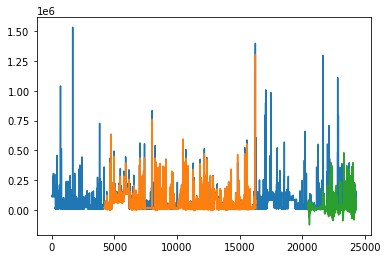

In [ ]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()